In [154]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer as Tfidf
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
%matplotlib inline

In [3]:
data = pd.read_json('json_2015.json')

In [4]:
data.head()

,business_id,cool,date,funny,stars,text,useful,user_id
0,vT12uXtdBQ10_lUcl-M40w,0,2015-01-01,0,1,terrible experience....I am a local first of a...,0,C_xtIn19eKivN335dzjadg
1,aWMxTWSEqBvH2KhdGPLibQ,0,2015-01-01,0,3,Bad service at this location.\n\nGood iced cof...,0,T7J9ae0wTskrI_Bgwp-4cA
2,Z98h1BhssZeFfZvcVTYOpw,0,2015-01-01,0,2,We have been to Maya's many times since it fir...,1,O7WaUuYwX45Ia6Mvf01UCw
3,3rwM9fPYPk9qDkEBOhyHbg,1,2015-01-01,0,5,"booked the hotel for new years, over the phone...",1,kq-4vbC1cHQbRKyDmwERSA
4,JpYn_HdxQNZQSlWWv4P6Iw,0,2015-01-01,0,3,"Good, not great. Not a ton of tea options but ...",1,XweddetOpWNuJQ5mLb_5JQ


We'll start by drawing a 50,000 observation sample for the dataset to make parameter tuning reasonable – the full dataset can take a very long time to run.

I've also decided to take only the top 10,000 words in the vocabulary across reviews. Messing with this number seemed to make relatively little difference in accuracy (slight improvement over no limit).

In [177]:
samp = data.sample(50000) #draw samples

In [178]:
vectorizer = CountVectorizer(stop_words='english', binary=False, max_features=10000) #using non-binary Count Vec.
reviews = samp.text.values

#tokenize words
x = vectorizer.fit_transform(reviews)

In [179]:
binary_y = [] #class observations according to whether they have at least one "helpful" vote

for score in samp.useful.values:
    i = 1 if score > 0 else 0
    binary_y.append(i)

C= 0.0001 : 0.648200018119
C= 0.001 : 0.665199987732
C= 0.01 : 0.667199959733
C= 0.1 : 0.656480036126
C= 1 : 0.632299974905
C= 10 : 0.609219909686
C= 100 : 0.604479922882


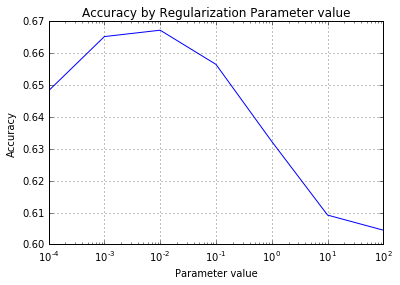

In [181]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
scores = []
for c in cvals: #try cross validating the data with different regularization parameters
    log_model = LogReg(C=c, penalty='l2') #initiate unregularized logistic regression model
    score = cross_val_score(log_model, x, binary_y, n_jobs=-1).mean() #cross validate
    scores.append(score)
    print "C=",c ,":", score
    
    
plt.plot(cvals, scores)
plt.xscale('log')
plt.title("Accuracy by Regularization Parameter value")
plt.xlabel("Parameter value")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [152]:
log_model = LogReg(C=0.01, penalty='l2') #initialize logistic regression model
print "Cross Validated Accuracy on Sample:", cross_val_score(log_model, x, binary_y, n_jobs=-1).mean()

Cross Validated Accuracy on Sample: 0.663440019331


Let's take a closer look at what's going on. What kinds of mistakes does our baseline model make?

In [171]:
log_model = LogReg(C=0.01, penalty='l2') #initialize logistic regression model
log_model.fit(x, binary_y)
y_pred = log_model.predict(x)
binary_y = np.array(binary_y)

tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

print "NO CLASS BALANCE CORRECTION"
print confusion_matrix(binary_y, y_pred)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on Positive Reviews:", np.mean(y_pred[binary_y == 1] == binary_y[binary_y == 1])
print "Accuracy on Negative Reviews:", np.mean(y_pred[binary_y == 0] == binary_y[binary_y == 0])

print "Overall F1 Score:", cross_val_score(log_model, x, binary_y, n_jobs=-1, scoring='f1').mean()

#BALANCED CLASSES
log_model = LogReg(C=0.01, penalty='l2', class_weight='balanced') #initialize logistic regression model
log_model.fit(x, binary_y)
y_pred = log_model.predict(x)
binary_y = np.array(binary_y)

tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(binary_y, y_pred)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on Positive Reviews:", np.mean(y_pred[binary_y == 1] == binary_y[binary_y == 1])
print "Accuracy on Negative Reviews:", np.mean(y_pred[binary_y == 0] == binary_y[binary_y == 0])

print "Overall F1 Score:", cross_val_score(log_model, x, binary_y, n_jobs=-1, scoring='f1').mean()

NO CLASS BALANCE CORRECTION
[[28774  2303]
 [12731  6192]]

False Positive Rate: 0.0741062522122
False Negative Rate: 0.672779157639
True Positive Rate: 0.72889935256
True Negative Rate: 0.693265871582

Accuracy on Positive Reviews: 0.327220842361
Accuracy on Negative Reviews: 0.925893747788
Overall F1 Score: 0.382408975724


WITH CLASS BALANCE CORRECTION
[[24058  7019]
 [ 8277 10646]]

False Positive Rate: 0.225858351836
False Negative Rate: 0.43740421709
True Positive Rate: 0.602660628361
True Negative Rate: 0.744023503943

Accuracy on Positive Reviews: 0.56259578291
Accuracy on Negative Reviews: 0.774141648164
Overall F1 Score: 0.513544170346


It appears that our model is having a difficult time dealing with the class imbalance. Our F1 metric and confusion matrices are instructive here – There are a large number of false negatives (helpful reviews labeled as unhelpful) in the unweighted sample. Assigning balanced weighting balances the false positive and false negative rates at the cost of a slight overall dip in accuracy. It leads to a significant increase in F1 score, a more robust metric for classification models.

Now let's use the same procedure on the full dataset using the C parameter we selected. This dataset seems to benefit from relatively strong regularization.

In [183]:
#same procedure on full dataset

vectorizer = CountVectorizer(stop_words='english', binary=False, max_features=10000) #using non-binary Count Vec.
reviews = data.text.values
x = vectorizer.fit_transform(reviews)

binary_y = []

for score in data.useful.values:
    i = 1 if score > 0 else 0
    binary_y.append(i)

In [184]:
log_model = LogReg(C=0.01, penalty='l2', class_weight='balanced') #initialize logistic regression model
print "Accuracy:", cross_val_score(log_model, x, binary_y, n_jobs=-1).mean()
print "F1 Score:",cross_val_score(log_model, x, binary_y, scoring='f1', n_jobs=-1).mean()

log_model.fit(x, binary_y)
y_pred = log_model.predict(x)
binary_y = np.array(binary_y)

tn, fp, fn, tp = confusion_matrix(binary_y, y_pred).ravel() #from sklearn docs

print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(binary_y, y_pred)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on Positive Reviews:", np.mean(y_pred[binary_y == 1] == binary_y[binary_y == 1])
print "Accuracy on Negative Reviews:", np.mean(y_pred[binary_y == 0] == binary_y[binary_y == 0])

print "Overall F1 Score:", cross_val_score(log_model, x, binary_y, n_jobs=-1, scoring='f1').mean()

Accuracy: 0.655811589563
F1 Score: 0.525505082492


WITH CLASS BALANCE CORRECTION
[[314277 101194]
 [119596 131748]]

False Positive Rate: 0.243564532783
False Negative Rate: 0.475825959641
True Positive Rate: 0.56558284895
True Negative Rate: 0.724352517903

Accuracy on Positive Reviews: 0.524174040359
Accuracy on Negative Reviews: 0.756435467217
Overall F1 Score: 0.525505082492


Overall, while our baseline model establishes some degree of separation between helpful and unhelpful reviews it seems to have a relatively low accuracy and F1 score even when tuned. This is likely due to a confounding element of our question: the reality that reviews can lack "useful" votes for multiple reasons. 

On one hand, a review can have no useful votes when it actually contains useless content. This is the sort of review we'd like to classify as 0 or useless. On the other hand, a great review can recieve no useful votes simply because it goes unnoticed by other Yelp users. This likely impedes our model's capacity to make solid predictions regarding a review's helpfulness. A "denominator" value such as the sort seen in the Amazon dataset we looked at previously would help alleviate this issue.

Given this difficulty, it will make sense for us to fit some additional models to the data to see which works best. Playing with class weights would also make sense, as the model currently seems to be making a fair number of false negative errors (which are severely impacting its performance). We can also explore other proxies for review quality, such as ratios between the different review classifications (useful, cool, funny) for a different review. Our baseline modeling approach is also extensible to direct analysis of the lingustic characteristics correlating with these other classifications.

This model represents a decent start to what will be a more involved and nuanced project. Our next steps will be to play around with other modeling techniques and adjust parameters and inputs/weighting to try to reduce our false postiive and negative rates.